In [33]:
import pvdeg
from pvdeg.geospatial import output_template
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import xarray as xr
import dask.array as da
import pickle

In [34]:
locationGetter = pvdeg.scenario.GeospatialScenario()

locationGetter.addLocation(country="United States", downsample_factor=80)

/home/tford/.conda-envs/rpp/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


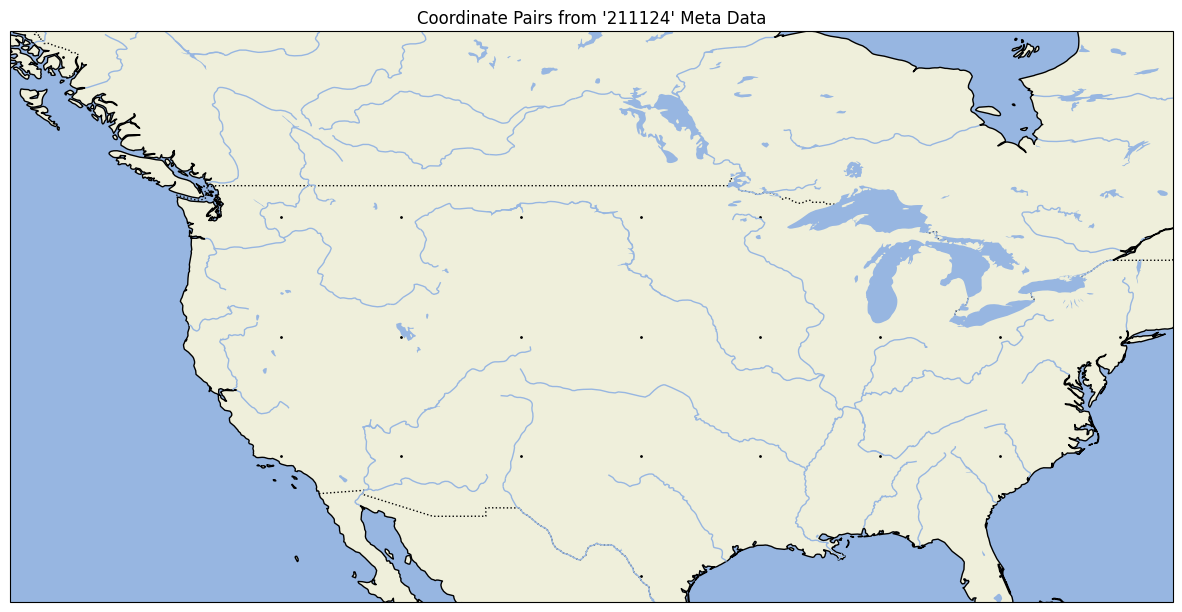

In [35]:
locationGetter.plot_coords()

In [36]:
geo_weather, geo_meta = locationGetter.geospatial_data()

geo_meta = geo_meta[geo_meta['state'] != "Alaska"]
geo_weather = geo_weather.sel(gid=geo_meta.index)

In [37]:
shapes = {
    "annual_poa" : ("gid",),
    "ground_irradiance" : ("gid", "time", "distance")
}

template = pvdeg.geospatial.output_template(
    ds_gids = geo_weather,
    shapes = shapes,
    add_dims={"distance" : 10}, # this will autogenerate a range of length 10 for the coordinate axis
)

In [38]:
pysam_fake_res = pvdeg.geospatial.analysis(
    weather_ds = geo_weather,
    meta_df = geo_meta,
    func = pvdeg.pysam.sample_pysam_result, # this doesnt actually calculate using pysam, returns duplicate saved pysam sim value each time it is called
    template = template,
)

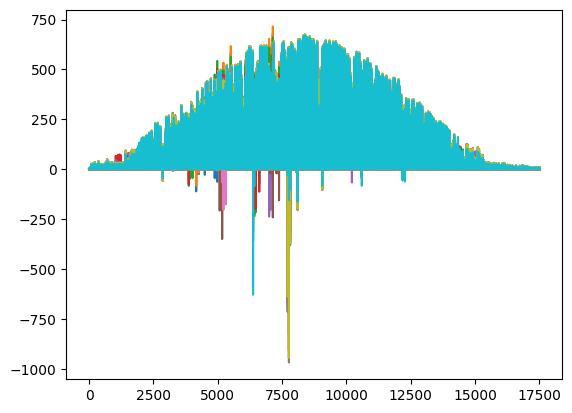

In [39]:
# this plot is not great because there are a lot of rows with zero values
# each line represents the temperature at a fixed distance over time.
plt.plot(pysam_fake_res.isel(latitude=0, longitude=3)["ground_irradiance"])

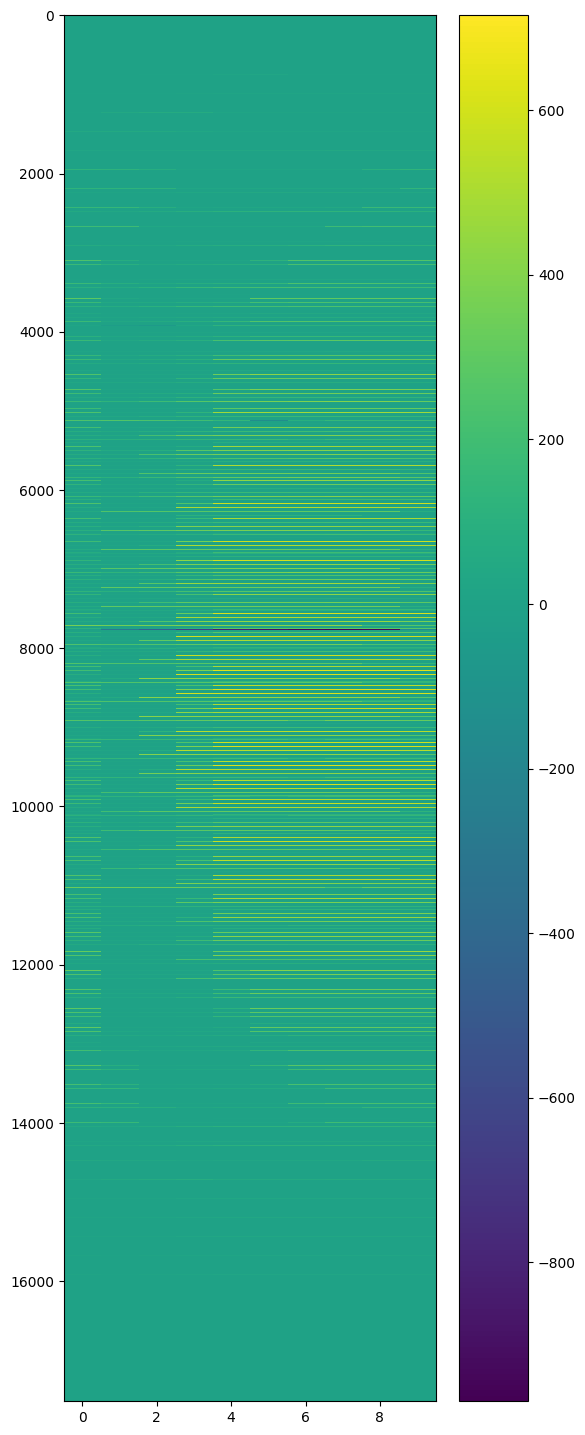

In [40]:
single_location_irradiance = pysam_fake_res.isel(latitude=0, longitude=3)["ground_irradiance"]

plt.figure(figsize=(6,18))

plt.imshow(single_location_irradiance, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar()

In [41]:
pysam_fake_res.isel(latitude=0, longitude=3)["ground_irradiance"]

<xarray.DataArray 'ground_irradiance' (time: 17520, distance: 10)> Size: 1MB
dask.array<getitem, shape=(17520, 10), dtype=float64, chunksize=(17520, 10), chunktype=numpy.ndarray>
Coordinates:
    latitude   float32 4B 28.13
    longitude  float32 4B -99.94
  * time       (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T23:30:00
  * distance   (distance) int64 80B 0 1 2 3 4 5 6 7 8 9

In [42]:
nonzero_mask = np.any(single_location_irradiance != 0, axis=1).compute()

nonzero_da = pysam_fake_res.isel(latitude=0, longitude=3)["ground_irradiance"].isel(time=nonzero_mask)

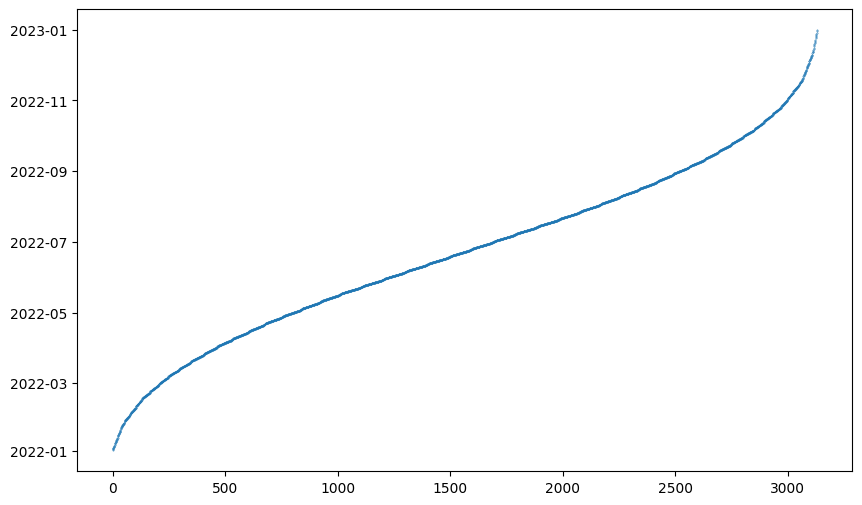

In [43]:
plt.figure(figsize=(10,6))
plt.scatter(np.arange(nonzero_da.sizes["time"]), nonzero_da.time, s=0.1)

This appears to happen because the model only calculates given certain constraints. We take less calculations near the end of the year and more in the center. We can probably ignore this safely and simply take a monthly average.

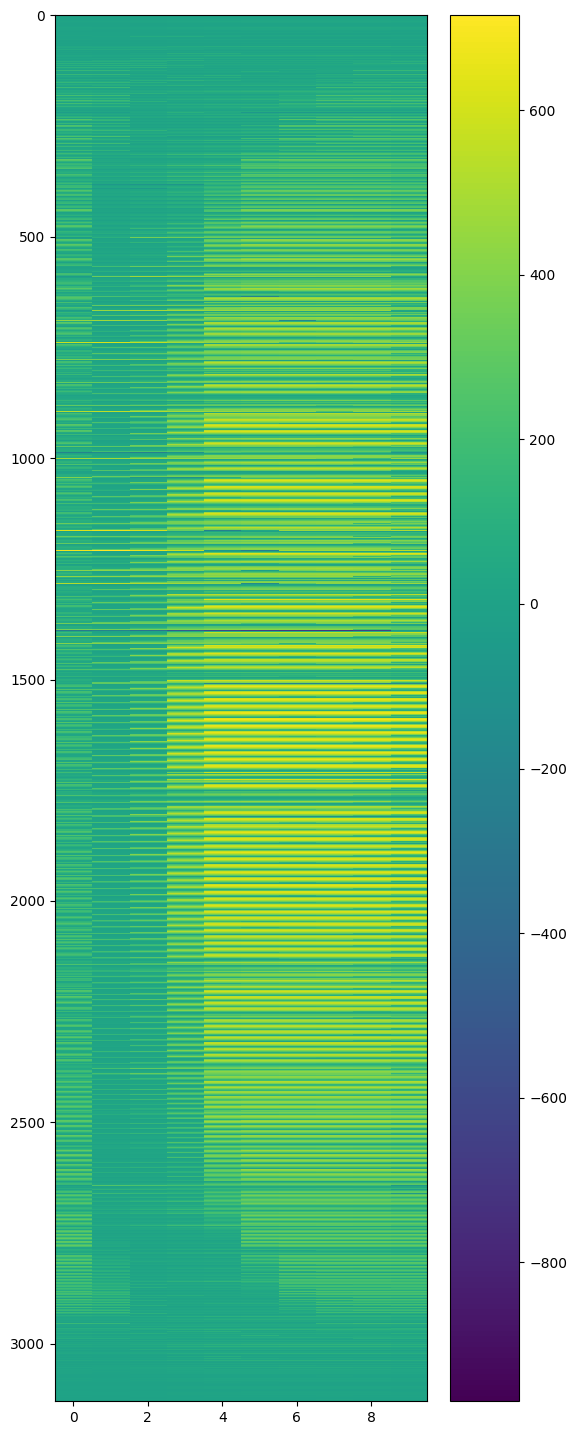

In [44]:
plt.figure(figsize=(6,18))

plt.imshow(nonzero_da, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar()

In [ ]:
nonzero_da

In [ ]:
month_ground_irradiance = nonzero_da.groupby(nonzero_da.time.dt.month).mean()

In [ ]:
# this plot does not have labels but each line represents the avg irradiance at a
# fixed distance from the array for each month

plt.plot(month_ground_irradiance)

In [5]:
weather_df = geo_weather.isel(gid=0).to_dataframe()
meta_dict = geo_meta.iloc[0].to_dict()

# path to files
# 01 - 10
options = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

config_dict = {
    option: f"/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/{option}/{option}_pvsamv1.json" for option in options
}

config_dict

{'01': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/01/01_pvsamv1.json',
 '02': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/02/02_pvsamv1.json',
 '03': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/03/03_pvsamv1.json',
 '04': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/04/04_pvsamv1.json',
 '05': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/05/05_pvsamv1.json',
 '06': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/06/06_pvsamv1.json',
 '07': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/07/07_pvsamv1.json',
 '08': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/08/08_pvsamv1.json',
 '09': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/09/09_pvsamv1.json',
 '10': '/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/10/10_pvsamv1.json'}

We run two different configs out of the 10 provided. The annual POA appears the same for these configs but the ground irradiance values are different as shown below. The distance indicies are not the real indexes.

In [6]:
config_files1={'pv' : config_dict['01']}
config_files2={'pv' : config_dict['02']}

res1 = pvdeg.pysam.inspire_ground_irradiance(weather_df, meta_dict, config_files1) 
res2 = pvdeg.pysam.inspire_ground_irradiance(weather_df, meta_dict, config_files2) 

ds1 = pvdeg.pysam._handle_pysam_return(res1)
ds2 = pvdeg.pysam._handle_pysam_return(res2)

In [30]:
ds1

<xarray.Dataset> Size: 2MB
Dimensions:            (time: 17520, distance: 10)
Coordinates:
  * time               (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T...
  * distance           (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    annual_poa         float64 8B 2.736e+05
    ground_irradiance  (time, distance) float64 1MB dask.array<chunksize=(17520, 10), meta=np.ndarray>

In [31]:
ds2

<xarray.Dataset> Size: 2MB
Dimensions:            (time: 17520, distance: 10)
Coordinates:
  * time               (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T...
  * distance           (distance) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    annual_poa         float64 8B 2.736e+05
    ground_irradiance  (time, distance) float64 1MB dask.array<chunksize=(17520, 10), meta=np.ndarray>

In [28]:
mask = np.any(ds1.ground_irradiance != 0, axis=1)

nonzero = ds1.ground_irradiance.compute()[mask.compute()]

nonzero.compute()

<xarray.DataArray 'ground_irradiance' (time: 3156, distance: 10)> Size: 252kB
array([[5.75000778, 6.81571978, 8.5343234 , ..., 8.44491123, 6.84407973,
        5.77561202],
       [3.23635362, 3.84641097, 4.82869613, ..., 4.77427455, 3.86100979,
        3.251067  ],
       [2.83297997, 3.36778282, 4.22750632, ..., 4.17682637, 3.37907801,
        2.84592762],
       ...,
       [2.82727475, 3.35709743, 4.21585467, ..., 4.18072614, 3.37589277,
        2.83982618],
       [6.14378031, 7.28084641, 9.1213216 , ..., 9.04050337, 7.31845355,
        6.1708254 ],
       [4.44587279, 5.28112444, 6.6310527 , ..., 6.56734252, 5.30656218,
        4.46582299]])
Coordinates:
  * time      (time) datetime64[ns] 25kB 2022-01-01T16:00:00 ... 2022-12-31T1...
  * distance  (distance) int64 80B 0 1 2 3 4 5 6 7 8 9

In [29]:
mask = np.any(ds2.ground_irradiance != 0, axis=1)

nonzero = ds2.ground_irradiance.compute()[mask.compute()]

nonzero.compute()

<xarray.DataArray 'ground_irradiance' (time: 3156, distance: 10)> Size: 252kB
array([[7.06233363, 7.39554398, 8.11977724, ..., 8.10870709, 7.49858932,
        7.09628666],
       [3.98710499, 4.17824515, 4.59019211, ..., 4.5834376 , 4.23525868,
        4.00591693],
       [3.49067497, 3.65859914, 4.01731711, ..., 4.01100985, 3.70677081,
        3.50659409],
       ...,
       [3.48102596, 3.64553123, 4.01318906, ..., 4.00887056, 3.7024543 ,
        3.49970561],
       [7.54605911, 7.89978085, 8.68438986, ..., 8.67443697, 8.01862736,
        7.58509934],
       [5.4753274 , 5.73569692, 6.30850165, ..., 6.30063946, 5.82034418,
        5.50316637]])
Coordinates:
  * time      (time) datetime64[ns] 25kB 2022-01-01T16:00:00 ... 2022-12-31T1...
  * distance  (distance) int64 80B 0 1 2 3 4 5 6 7 8 9